# Improving Brewster Paper

In the original paper **General characterization of qubit-preserving impairments on two-qubit Bell nonlocality**, a technique was presented that would correct errors such as polarization misalignments of entangled qubits by optimizing a set of unitary gets for each of the qubits Alice and Bob have. A follow up paper, **Automated Bell inequality violation searches for estimating entanglement quality in fiber**, determined that the Nelder-Mead Method was deemed to be the best method for optimization, though Bayesian Optimization was also quoted as being a close second. 

Previous work on this repo has simulated CHSH games on a quantum network using SeQuEnCe, with more recent additions implementing polarization misalignment and the proposed corrective technique by the above papers. However, we believe that we can improve this process further by utilizing more suitable optimization techniques. The below experiment uses COnstrained Optimization BY Linear Approximation, or COBYLA, to better approximate better alphas in a noisy quantum environment.  

In [47]:
import network_module
from scipy.optimize import minimize
import numpy as np

In [48]:
theta1 = 0.7854          
theta2 = 0          
theta3 = -0.3927        
theta4 = 0.3927

In [49]:
from bayes_opt import BayesianOptimization
import numpy as np
import time

def BayesOPT(deltas, time_limit=400, precision=2500):
    iteration_s_values = []
    time_values = []
    winrate_best = -np.inf
    best_S = 0
    start_time = time.time()

    # Define the CHSH evaluation function with timing and logging
    def simulated_chsh(alpha1, alpha2, alpha3):
        nonlocal best_S,winrate_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit exceeded")

        g = network_module.Game(deltas=deltas, fid=0.9)
        alphas_alice = [alpha1, alpha2, alpha3]
        alphas_bob = [0,0,0]
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        # print(winrate)
        S = g.referee.compute_chsh_s()

        print(winrate,S)
        # Log best-so-far S and corresponding timestamp
        if winrate > winrate_best:
            winrate_best = winrate
            best_S = S
        iteration_s_values.append(best_S)
        time_values.append(elapsed)

        return winrate

    # Define bounds
    pbounds = {
        'alpha1': (-np.pi, np.pi),
        'alpha2': (-np.pi, np.pi),
        'alpha3': (-np.pi, np.pi),
        # 'alpha4': (-np.pi, np.pi),
        # 'alpha5': (-np.pi, np.pi),
        # 'alpha6': (-np.pi, np.pi),
    }

    # Set up optimizer
    optimizer = BayesianOptimization(
        f=simulated_chsh,
        pbounds=pbounds,
        verbose=0
    )

    try:
        optimizer.maximize(
            init_points=4,
            n_iter=100000  # allow many iterations; we stop by timeout
        )
    except TimeoutError:
        pass

    total_time = time.time() - start_time
    
    return list(optimizer.max['params'].values()), total_time, iteration_s_values,time_values

In [50]:
import numpy as np

def wrap_angles(x):
    """Map angles to (-pi, pi], vectorized."""
    y = (x + np.pi) % (2*np.pi) - np.pi        # gives (-pi, pi]
    # ensure -pi maps to +pi to avoid duplicate endpoints
    y = np.where(np.isclose(y, -np.pi), np.pi, y)
    return y


In [82]:
def Nelder_Mead(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best = -np.inf
    S_best = 0
    S_curve = []
    time_curve = []
    best_angles = []
    
    def objective(x):
        nonlocal S_best,best_angles,winrate_best
        # print("Alphas:",x)
        # nonlocal S_best
        x = wrap_angles(np.asarray(x, dtype=float))
        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        alphas_bob = [0,0,0]

        g = network_module.Game(deltas=deltas, fid=1)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()
        # print(winrate,S)
        if winrate > winrate_best:
            winrate_best = winrate
            best_angles = x
            S_best = S

        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate  # Minimization

    # x0 = np.random.uniform(-np.pi, np.pi, 6)
    x0 = np.zeros(3)

    try:
        res = minimize(objective, x0, method='Nelder-Mead',options={'maxiter': 10000,'adaptive': True,})
    except TimeoutError:
        pass
    total_time = time.time() - start_time
    return best_angles, total_time, S_curve, time_curve

In [93]:
import numpy as np
import time
from scipy.optimize import minimize

TWO_PI = 2*np.pi

def Nelder_Mead(deltas, time_limit=400, precision=2500, simplex_step=0.8, seed=None):
    rng = np.random.default_rng(seed)

    start_time = time.time()
    winrate_best = -np.inf
    S_best = -np.inf
    S_curve = []
    time_curve = []
    best_angles = None
    last_x_eval = None  # fallback if timeout happens before improvement

    def wrap_angles(a):
        # map R -> (-pi, pi]
        return (a + np.pi) % TWO_PI - np.pi

    def make_initial_simplex(center, step=simplex_step):
        # Build a "fat" simplex around the center
        center = center.copy()
        simplex = [center]
        n = center.size
        for i in range(n):
            v = center.copy()
            v[i] = v[i] + step   # do NOT wrap optimizer variables here
            simplex.append(v)
        return np.array(simplex)

    def objective(x):
        nonlocal S_best, best_angles, winrate_best, last_x_eval
        last_x_eval = x.copy()

        # Enforce time budget
        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        # Only wrap when passing to the simulator
        x_wrapped = wrap_angles(np.asarray(x, dtype=float))
        alphas_alice = x_wrapped[0:3]
        alphas_bob = [0,0,0]

        g = network_module.Game(deltas=deltas, fid=1)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()
        # print("Alphas (wrapped):", x_wrapped, " winrate:", winrate, " S:", S)

        # Track best by winrate (objective); keep S_best and angles alongside
        # print(winrate,S)
        if winrate > winrate_best:
            winrate_best = winrate
            S_best = S
            best_angles = x_wrapped.copy()

        # Convergence traces (best-so-far S vs time)
        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate  # NM minimizes

    # ----- Initialization -----
    # Random center in (-pi, pi]; keeps things from getting stuck at trivial zero
    x0 = rng.uniform(-np.pi, np.pi, size=3)
    init_simplex = make_initial_simplex(x0, step=simplex_step)

    try:
        res = minimize(
            objective,
            x0,
            method='Nelder-Mead',
            options={
                'initial_simplex': init_simplex,
                'adaptive': True,
                'maxiter': 10000,
                'maxfev': 20000,
                'xatol': 1e-3,
                'fatol': 1e-3,
                'disp': True,
            },
        )
    except TimeoutError:
        res = None  # we’ll return best-so-far

    total_time = time.time() - start_time

    # Fallbacks if nothing improved before timeout
    if best_angles is None:
        # If we never improved, return the last evaluated wrapped point
        best_angles = wrap_angles(last_x_eval) if last_x_eval is not None else wrap_angles(x0)

    return best_angles, total_time, S_curve, time_curve


In [94]:
def COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best_C = -np.inf
    S_best_C = 0
    S_curve = []
    time_curve = []
    best_angles_C = []
    
    def objective(x):
        nonlocal S_best_C,best_angles_C,winrate_best_C
        # print("Alphas:",x)
        # nonlocal S_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        # alphas_bob = x[3:]
        alphas_bob = [0,0,0]

        g = network_module.Game(deltas=deltas, fid=1)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()
        # print(winrate,S)
        if winrate > winrate_best_C:
            winrate_best_C = winrate
            best_angles_C = x
            S_best_C = S

        S_curve.append(S_best_C)
        time_curve.append(elapsed)

        return -winrate   # Minimization

    # x0 = np.random.uniform(-np.pi, np.pi, 6)
    x0 = np.zeros(3)
    pi_val = np.pi
    # cons = []
    # for i in range(3):
    # # x[i] >= -pi  ->  x[i] + pi >= 0
    #     cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] + pi_val})
    # # x[i] <= pi   ->  pi - x[i] >= 0
    #     cons.append({'type': 'ineq', 'fun': lambda x, i=i: pi_val - x[i]})

    try:
        # res = minimize(objective, x0, method='COBYLA', constraints=cons,options={'maxiter': 10000})
        res = minimize(objective, x0, method='COBYLA',options={'maxiter': 10000})
    except TimeoutError:
        pass
    total_time = time.time() - start_time
    return best_angles_C, total_time, S_curve, time_curve

In [95]:
# Experiments
import time
num_exp = 2

# Convergence progress
BO_conv = []
NM_conv = []
COB_conv = []

# Time curves (per iteration)
BO_time_curve = []
NM_time_curve = []
COB_time_curve = []

# Validation results
BO_res = []
NM_res = []
COB_res = []

# Total optimization time
BO_time = []
NM_time = []
COB_time = []

for x in range(num_exp):
    print("Iteration:", x)
    deltaA = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltaB = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltas = [deltaA, deltaB]

    # ----- Bayesian Optimization -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = BayesOPT(deltas, time_limit=400, precision=2500)
    end_time = time.time()
    
    BO_conv.append(progress)
    BO_time_curve.append(time_curve)
    BO_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    # alphas_bob = X_high_fid[3:6]
    alphas_bob = [0,0,0]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=1)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("Validation:", S_high)
    BO_res.append(S_high)

    # ----- Nelder-Mead -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = Nelder_Mead(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    NM_conv.append(progress)
    NM_time_curve.append(time_curve)
    NM_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    # alphas_bob = X_high_fid[3:6]
    alphas_bob = [0,0,0]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=1)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("VALIDATION:",S_high)
    NM_res.append(S_high) 

    # ----- COBYLA -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    COB_conv.append(progress)
    COB_time_curve.append(time_curve)
    COB_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    # alphas_bob = X_high_fid[3:]
    alphas_bob = [0,0,0]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=1)
    result = g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S = g.referee.compute_chsh_s()
    print("VALIDATION:",S,X_high_fid)
    COB_res.append(S)


Iteration: 0
0.5112 0.05899095175777497
0.4688 0.2666224957601133
0.78 2.246501089098239
0.4428 0.454419635859548
0.3372 1.31368869200366
0.7736 2.186924852086
0.3472 1.2195039966302148
0.6332 1.0744488841366489
0.752 2.0030947561356336
0.4136 0.7093803078055957
0.5496 0.3927192030485214
0.722 1.784891028213809
0.4684 0.2998564481202419
0.3424 1.2542106145483025
0.49 0.0550768040445212
0.7476 2.0019430407827747
0.5356 0.34405020942326686
0.784 2.27283679827071
0.494 0.05249065540603948
0.488 0.10612401897451529
0.4856 0.002873090481786189
0.7516 2.026341739763708
0.4852 0.05825117655563439
0.7836 2.270962087677736
0.5008 0.014571577129363078
0.4984 0.04807000599199518
0.5032 0.0744423414579457
0.5028 0.008808486378244385
0.5072 0.05518433887632035
0.4972 0.01250593499605357
0.5104 0.09087659330944975
0.78 2.2371399849052347
0.512 0.0924466500310055
0.5124 0.09701622302428758
0.4412 0.444633279137338
0.4716 0.25838746054010375
0.5028 0.018968309126867533
0.5584 0.42562435232061924
0.456

In [96]:
import statistics
print("Mean validation Bayesian Optimization:",statistics.mean(BO_res))
print("Standard Deviation Bayesian Optimization:",statistics.stdev(BO_res))

Mean validation Bayesian Optimization: 2.733781457785144
Standard Deviation Bayesian Optimization: 0.051643119365332016


In [97]:
print("Mean validation Nelder-Mead:",statistics.mean(NM_res))
print("Standard Deviation Nelder-Mead:",statistics.stdev(NM_res))

Mean validation Nelder-Mead: 2.803213268519394
Standard Deviation Nelder-Mead: 0.05044306008465312


In [98]:
print("Mean validation COBYLA:",statistics.mean(COB_res))
print("Standard Deviation COBYLA:",statistics.stdev(COB_res))

Mean validation COBYLA: 2.700402124783664
Standard Deviation COBYLA: 0.14505139090271774


In [99]:
def pad_with_last_value(runs):
    max_len = max(len(run) for run in runs)
    padded = np.array([
        np.pad(run, (0, max_len - len(run)), mode='edge')
        for run in runs
    ])
    return padded


In [100]:
BO_time_curve_padded = pad_with_last_value(BO_time_curve)
NM_time_curve_padded = pad_with_last_value(NM_time_curve)
COB_time_curve_padded = pad_with_last_value(COB_time_curve)

BO_conv_padded = pad_with_last_value(BO_conv)
NM_conv_padded = pad_with_last_value(NM_conv)
COB_conv_padded = pad_with_last_value(COB_conv)

# Compute mean + std over runs
BO_time_mean = BO_time_curve_padded.mean(axis=0)
BO_mean = BO_conv_padded.mean(axis=0)
BO_std  = BO_conv_padded.std(axis=0)

NM_time_mean = NM_time_curve_padded.mean(axis=0)
NM_mean = NM_conv_padded.mean(axis=0)
NM_std  = NM_conv_padded.std(axis=0)

COB_time_mean = COB_time_curve_padded.mean(axis=0)
COB_mean = COB_conv_padded.mean(axis=0)
COB_std  = COB_conv_padded.std(axis=0)


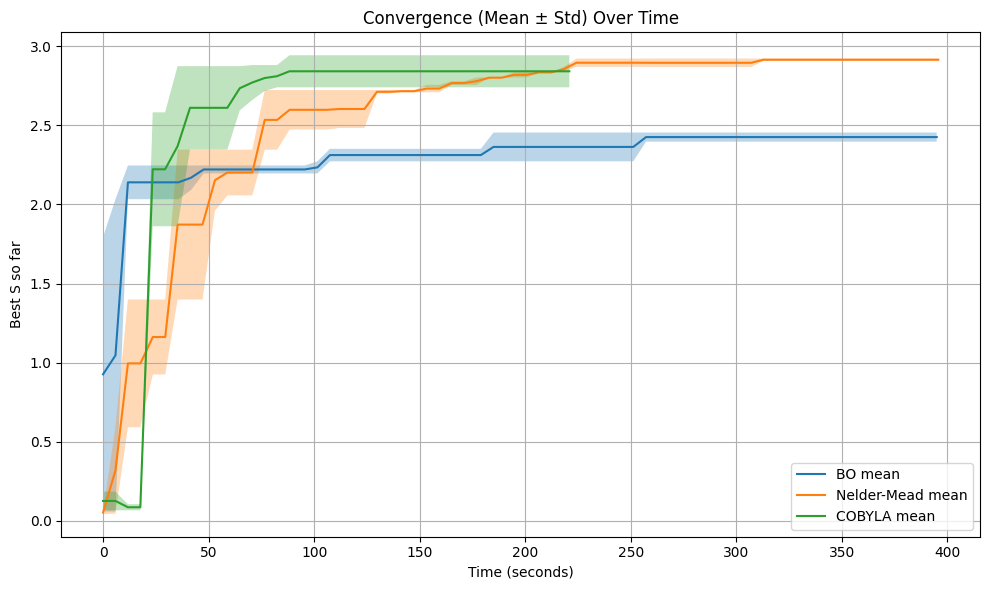

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(BO_time_mean, BO_mean, label='BO mean')
plt.fill_between(BO_time_mean, BO_mean - BO_std, BO_mean + BO_std, alpha=0.3)

plt.plot(NM_time_mean, NM_mean, label='Nelder-Mead mean')
plt.fill_between(NM_time_mean, NM_mean - NM_std, NM_mean + NM_std, alpha=0.3)

plt.plot(COB_time_mean, COB_mean, label='COBYLA mean')
plt.fill_between(COB_time_mean, COB_mean - COB_std, COB_mean + COB_std, alpha=0.3)

plt.xlabel('Time (seconds)')
plt.ylabel('Best S so far')
plt.title('Convergence (Mean ± Std) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()